<a href="https://colab.research.google.com/github/duaneywadey/A-collection-of-Jupyter-notebooks-and-CSV-files/blob/collection-of-models/(LEGIT)_MODEL_BUILDING_ONLY_DiabetesNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [219]:
# Importing essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

# Loading the dataset
df = pd.read_csv('https://raw.githubusercontent.com/duaneywadey/Diabetes-Detection-Model/master/diabetes.csv')

# Renaming DiabetesPedigreeFunction as DPF
df = df.rename(columns={'DiabetesPedigreeFunction':'DPF'})



In [220]:
# Handling columns with zeroes

features = df.columns
cols = (df[features] == 0).sum()
print(cols)

Pregnancies      111
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
DPF                0
Age                0
Outcome          500
dtype: int64


In [221]:
# Replacing zeroes with NaN except for no. of pregnancies and outcome

df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [222]:
#Replace the null values with the median of that column:

df['Glucose'].fillna(df['Glucose'].median(), inplace =True)

df['BloodPressure'].fillna(df['BloodPressure'].median(), inplace =True)

df['BMI'].fillna(df['BMI'].median(), inplace =True)


In [223]:
# Handling missing Insulin values using Glucose 
by_Glucose_Age_Insulin_Grp = df.groupby(['Glucose'])
def fill_Insulin(series):
    return series.fillna(series.median())

df['Insulin'] = by_Glucose_Age_Insulin_Grp['Insulin'].transform(fill_Insulin)
df['Insulin'] = df['Insulin'].fillna(df['Insulin'].mean())


# Handling missing Skin Thickness values using BMI
by_BMI_Insulin = df.groupby(['BMI'])
def fill_Skinthickness(series):
    return series.fillna(series.mean())
    
df['SkinThickness'] = by_BMI_Insulin['SkinThickness'].transform(fill_Skinthickness)
df['SkinThickness'].fillna(df['SkinThickness'].mean(),inplace= True) 



/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/p

In [224]:
# Model Building
from sklearn.model_selection import train_test_split
X = df.drop(columns='Outcome')
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [225]:
# FEATURE ENGINEERING

from sklearn.preprocessing import MinMaxScaler,StandardScaler
mms = MinMaxScaler() # Normalization
sc = StandardScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

In [226]:
# Creating Random Forest Model
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=1000)

# Logistic Regression Algorithm
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state = 42)

# K nearest neighbors Algorithm
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 100, metric = 'minkowski', p = 2)

# Support Vector Classifier Algorithm
from sklearn.svm import SVC
svc = SVC(kernel = 'linear', random_state = 42)

# Artificial Neural Network
from sklearn.neural_network import MLPClassifier
nm_model = MLPClassifier(hidden_layer_sizes=(128,128))

# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
classifier_dt = DecisionTreeClassifier(random_state = 1000,max_depth = 4,min_samples_leaf = 1)

# XGBoost Classifier
from xgboost import XGBClassifier
classifier_xgb = XGBClassifier(learning_rate= 0.01,max_depth = 3,n_estimators = 1000)


# LGBM Classifier
from lightgbm import LGBMClassifier
lgbm_params = {
        'n_estimators': [100, 500, 1000, 2000],
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5,6],
        'learning_rate': [0.1,0.01,0.02,0.05],
        "min_child_samples": [5,10,20]}
lgbm = LGBMClassifier()

lgbm_cv_model = GridSearchCV(lgbm, lgbm_params, 
                             cv = 10, 
                             n_jobs = -1, 
                             verbose = 2)

# Best parameters are founded with GridSearchCV
lgbm = LGBMClassifier(learning_rate = 0.01, 
                       max_depth = 3,
                       subsample = 0.6,
                       n_estimators = 500,
                       min_child_samples = 20)

# Models List
models = [classifier, logreg, knn, classifier_dt]

In [227]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve

def model(classifier,x_train,y_train,x_test,y_test):
    classifier.fit(x_train,y_train)
    prediction = classifier.predict(x_test)
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier,x_train,y_train,cv = cv,scoring = 'roc_auc').mean()))
    print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))
    

def model_evaluation(classifier,x_test,y_test):
    
    # Confusion Matrix
    cm = confusion_matrix(y_test,classifier.predict(x_test))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = 'Blues',fmt ='')
    
    # Classification Report
    print(classification_report(y_test,classifier.predict(x_test)))



In [228]:
# MODEL EVALUATION

for m in models:
  print("\n", m, 'SCORE')
  model(m,X_train,y_train,X_test,y_test)



 RandomForestClassifier(n_estimators=1000) SCORE
Cross Validation Score :  81.53%
ROC_AUC Score :  74.78%

 LogisticRegression(random_state=42) SCORE
Cross Validation Score :  82.96%
ROC_AUC Score :  73.45%

 KNeighborsClassifier(n_neighbors=100) SCORE
Cross Validation Score :  81.83%
ROC_AUC Score :  74.39%

 DecisionTreeClassifier(max_depth=4, random_state=1000) SCORE
Cross Validation Score :  77.49%
ROC_AUC Score :  71.25%


In [229]:
# TRAIN DATA ACCURACY SCORE
print('TRAIN DATA ACCURACY TEST')
for m in models:
  print("\n",m.fit(X_train, y_train))
  print(m.score(X_train, y_train))

# TEST DATA ACCURACY SCORE
print('\nTEST DATA ACCURACY TEST')
for m in models:
  print("\n",m.fit(X_test, y_test))
  print(m.score(X_test, y_test))

TRAIN DATA ACCURACY TEST

 RandomForestClassifier(n_estimators=1000)
1.0

 LogisticRegression(random_state=42)
0.760586319218241

 KNeighborsClassifier(n_neighbors=100)
0.755700325732899

 DecisionTreeClassifier(max_depth=4, random_state=1000)
0.7850162866449512

TEST DATA ACCURACY TEST

 RandomForestClassifier(n_estimators=1000)
1.0

 LogisticRegression(random_state=42)
0.8051948051948052

 KNeighborsClassifier(n_neighbors=100)
0.6948051948051948

 DecisionTreeClassifier(max_depth=4, random_state=1000)
0.9025974025974026


In [237]:
# JOBLIB TEST

import joblib

print("JOBLIB TEST")
for m in models:
  modName = str(m)
  joblib.dump(m, modName)
  model = joblib.load(str(m))
  diabModel = model.predict_proba([[0,0,0,0,0,43.3,1,41]])
  for r in diabModel:
    print('\n',m)
    print("Chance of being diabetic: ", round(r[1] * 100),"%")




Test Data

 RandomForestClassifier(n_estimators=1000)
Chance of being diabetic:  22 %

 LogisticRegression(random_state=42)
Chance of being diabetic:  100 %

 KNeighborsClassifier(n_neighbors=100)
Chance of being diabetic:  43 %

 DecisionTreeClassifier(max_depth=4, random_state=1000)
Chance of being diabetic:  100 %


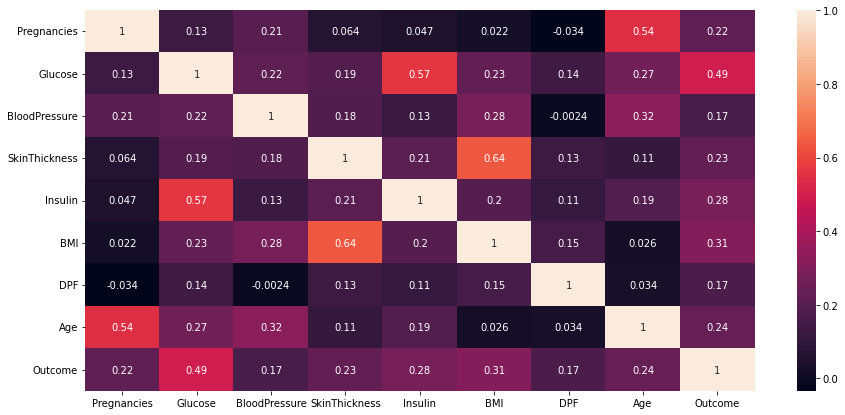

In [231]:
# CORRELATION SCORE

plt.figure(figsize= (15, 7))
sns.heatmap(df.corr(),annot= True)

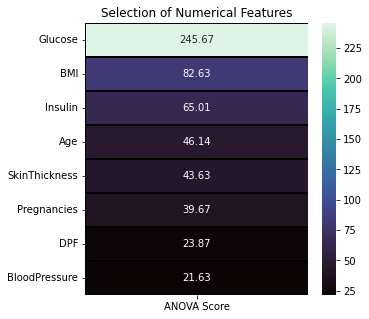

In [232]:
# PRESENTING THE BEST NUMERICAL FEATURES

allColumns = list(df.drop(columns=['Outcome']))

from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

features = df.loc[:,allColumns]
target = df.loc[:,'Outcome']

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'ANOVA Score'),annot = True,cmap = 'mako',linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Numerical Features');
